# Validation: Heldout Data Example

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* holds-out the final few days of the data, and see's if they can be predicted. 

The way I propose doing this is holding out the confirmed observations for the final three days of the day for every country, and then plotting it for validation. This effectively changes the output model. 

Compared to the above changes, lets make the following changes:

* Switch the prior to the ICL prior used. 
* Refine the country list
* switch to binary interventions
* use active rather than confirmed cases
* transform into log space

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

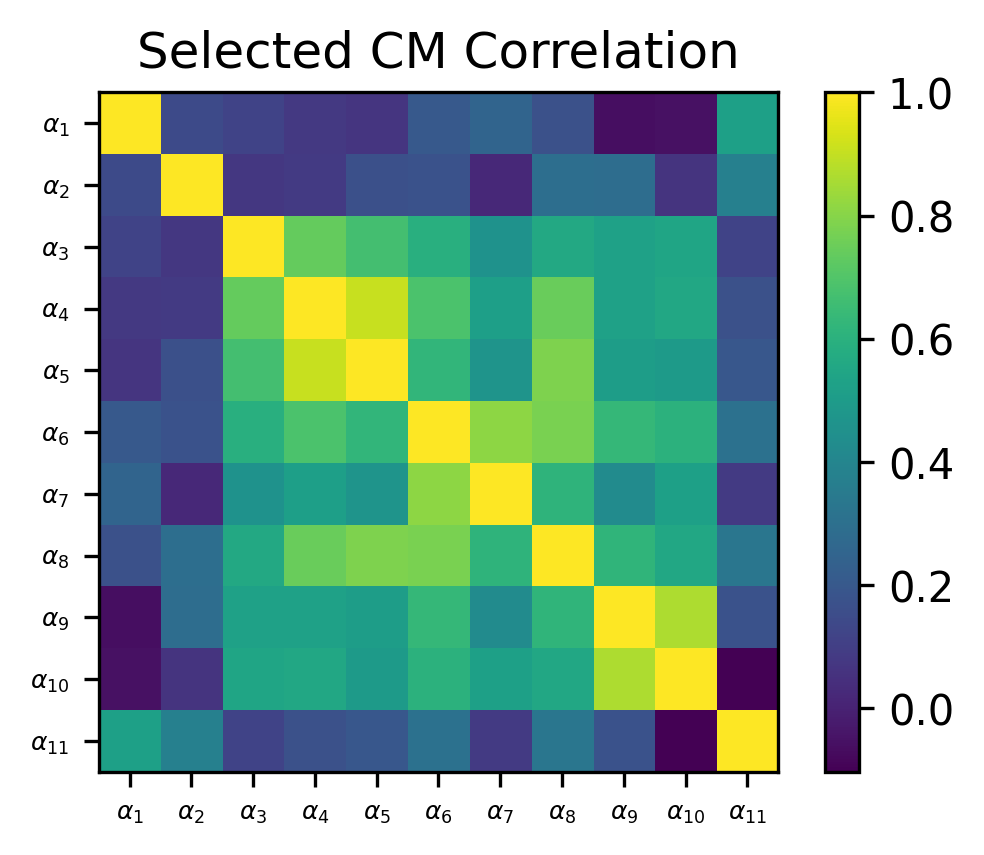

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-15",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [58]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']

#regions = regions[:10]
features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']
feature_labels = ['Ma>60',
                 'Asy Iso',
                 'Gath<10',
                 'Gath<100',
                 'Gath<1000',
                 'Bus Some',
                 'Bus Many',
                 'Sch Clsd',
                 'Curf sm',
                 'Curf strc',
                 'spc>.2']


dp = DataPreprocessor(end_date="2020-04-15")
data = dp.preprocess_data("../../data", regions, features)

def mask_region(d, region, start):
    heldout = d.Rs.index(region)
    d.Active.mask[heldout,start:] = True
    d.Confirmed.mask[heldout,start:] = True
    d.Deaths.mask[heldout,start:] = True

mask_region(data, 'AT', 32)
mask_region(data, 'BA', 40)
mask_region(data, 'BE', 35)
mask_region(data, 'CH', 35)
mask_region(data, 'CZ', 35)
mask_region(data, 'DE', 23)






In [59]:
with cm_effect.models.CMConfirmedAndDeaths(data) as model:
    model.build()

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedConfirmed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedDeaths contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [ ]:
with model:
    model.trace = pm.sample(2000, chains=2, cores=2, init='adapt_diag')

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ObservedDeaths_missing, ObservedConfirmed_missing, InitialSize, Growth, ReportRate, ReportRateBeta, ReportRateAlpha, CM_Alpha, RegionGrowthRate, HyperGrowthRateVar, HyperGrowthRateMean, DeathNoise, ConfirmationNoise]
INFO:pymc3:NUTS: [ObservedDeaths_missing, ObservedConfirmed_missing, InitialSize, Growth, ReportRate, ReportRateBeta, ReportRateAlpha, CM_Alpha, RegionGrowthRate, HyperGrowthRateVar, HyperGrowthRateMean, DeathNoise, ConfirmationNoise]
Sampling 2 chains, 0 divergences:   4%|▎         | 180/5000 [01:23<45:12,  1.78draws/s]  

In [ ]:
model.OR_indxs =  range(len(model.d.Rs))
model.ORs = model.d.Rs
model.ObservedDaysIndx = list(range(66)[10:])
model.ObservedDaysSlc= slice(10,66)
model.plot_region_predictions()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x152e9dfd0>,
      dtype=object)

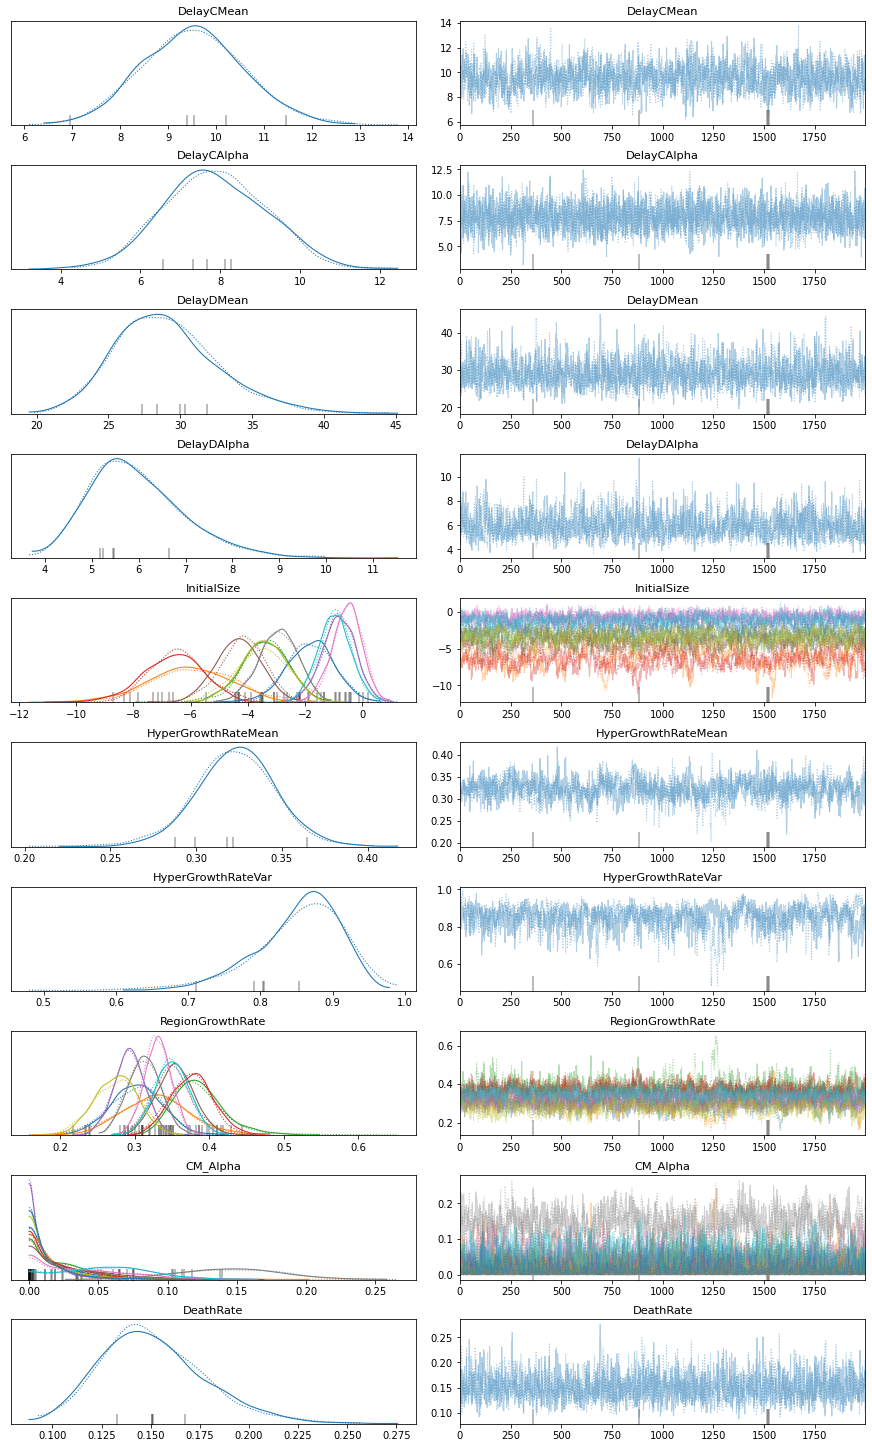

In [19]:
v =[
    'DelayCMean',
    'DelayCAlpha',
    'DelayDMean',
    'DelayDAlpha',
    'InitialSize',
    #'ConfirmationNoise',
    #'DeathNoise',
    'HyperGrowthRateMean',
    'HyperGrowthRateVar',
    'RegionGrowthRate',
    'CM_Alpha',
    'DeathRate',
    
]

pm.traceplot(model.trace, v)

In [20]:
good_trace = model.trace

In [21]:
start = model.trace.point(-1)

In [8]:
def norm(x): 
    s = T.sum(x)
    return x / s

DelayDDist = pm.NegativeBinomial.dist(mu=23.5, alpha=8)

nDelayD = 60
xD = np.arange( nDelayD)
DeathDelayProb = norm(T.exp(DelayDDist.logp(xD)))


(0.0, 0.1)

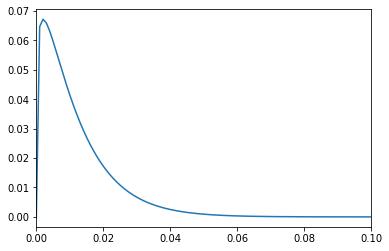

In [39]:
n=100
DelayDDist = pm.Beta.dist(.002*n+1,n+1 )

x = np.linspace(0,1,1000)
y = norm(T.exp(DelayDDist.logp(x))).tag.test_value
plt.plot(x, y)
plt.xlim(0,.1)


In [49]:

with cm_effect.models.CMConfirmedAndDeaths(data) as model2:
    model2.build()
    

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedConfirmed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedDeaths contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [50]:
with model2:
    model2.trace = pm.sample(500, chains=2, cores=2, init='adapt_diag', start=start)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ObservedDeaths_missing, ObservedConfirmed_missing, InitialSize, Growth, ReportRate, ReportRateBeta, ReportRateAlpha, CM_Alpha, RegionGrowthRate, HyperGrowthRateVar, HyperGrowthRateMean, DeathNoise, ConfirmationNoise]
INFO:pymc3:NUTS: [ObservedDeaths_missing, ObservedConfirmed_missing, InitialSize, Growth, ReportRate, ReportRateBeta, ReportRateAlpha, CM_Alpha, RegionGrowthRate, HyperGrowthRateVar, HyperGrowthRateMean, DeathNoise, ConfirmationNoise]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [09:22<00:00,  3.55draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


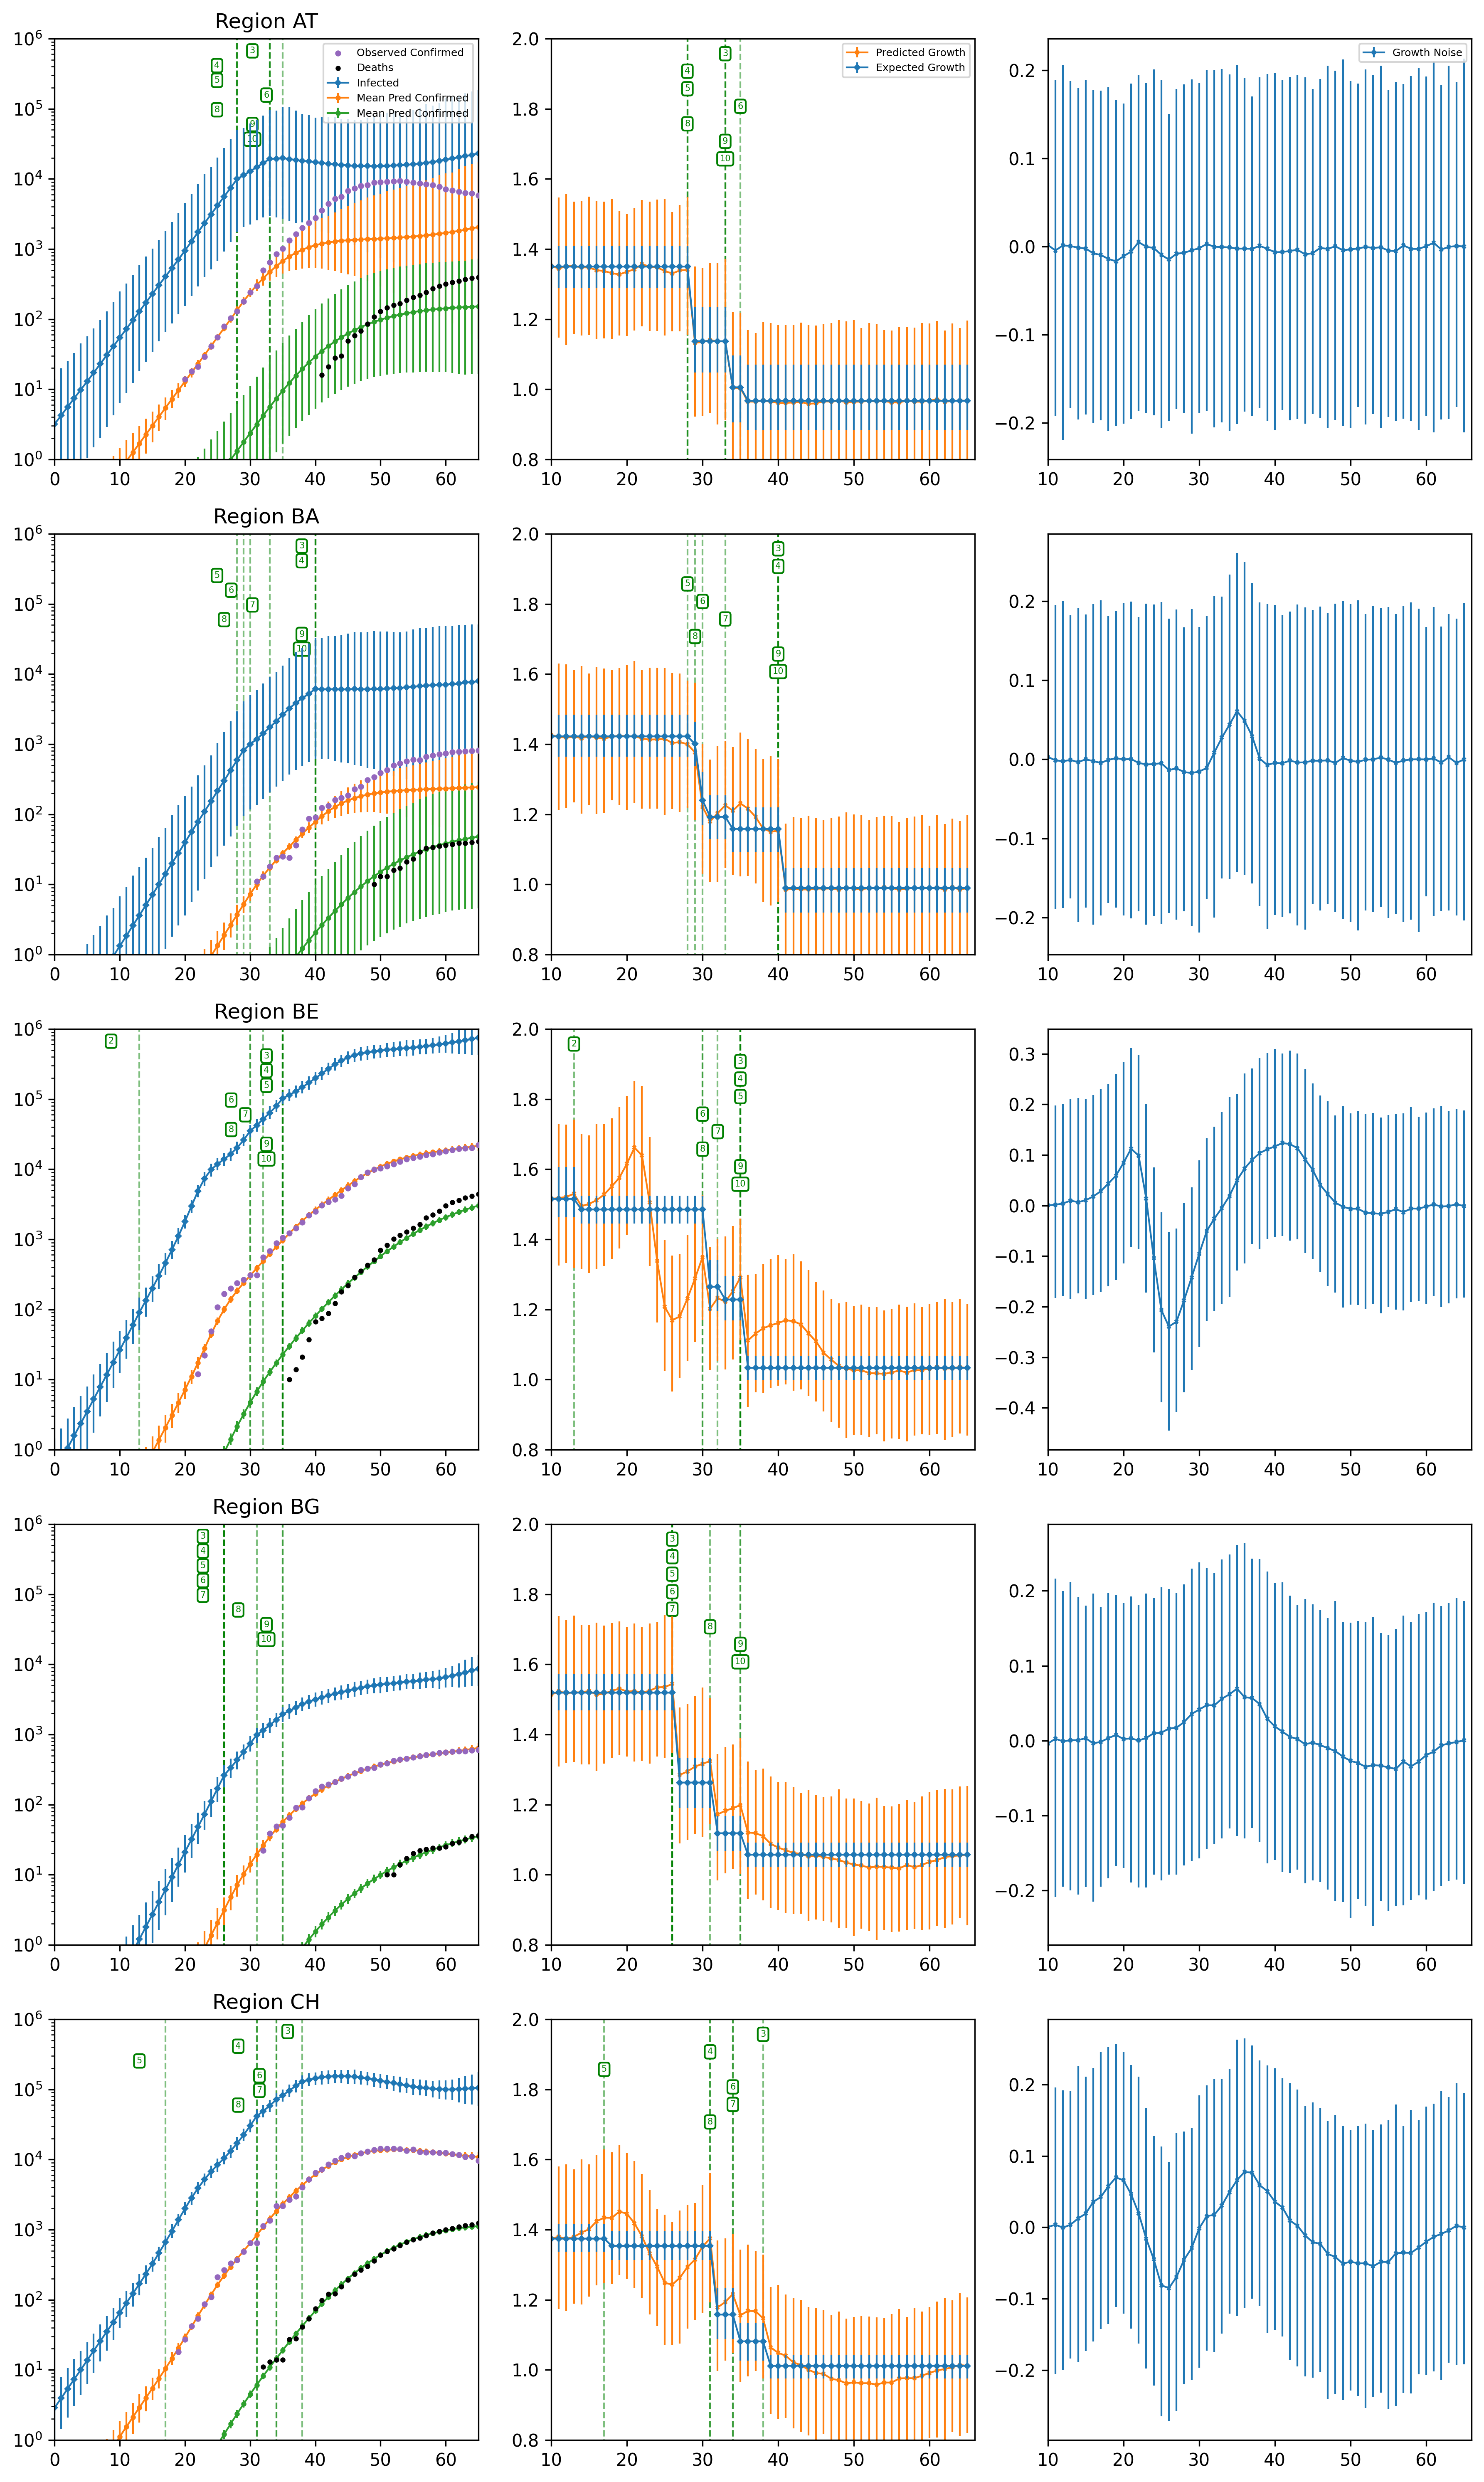

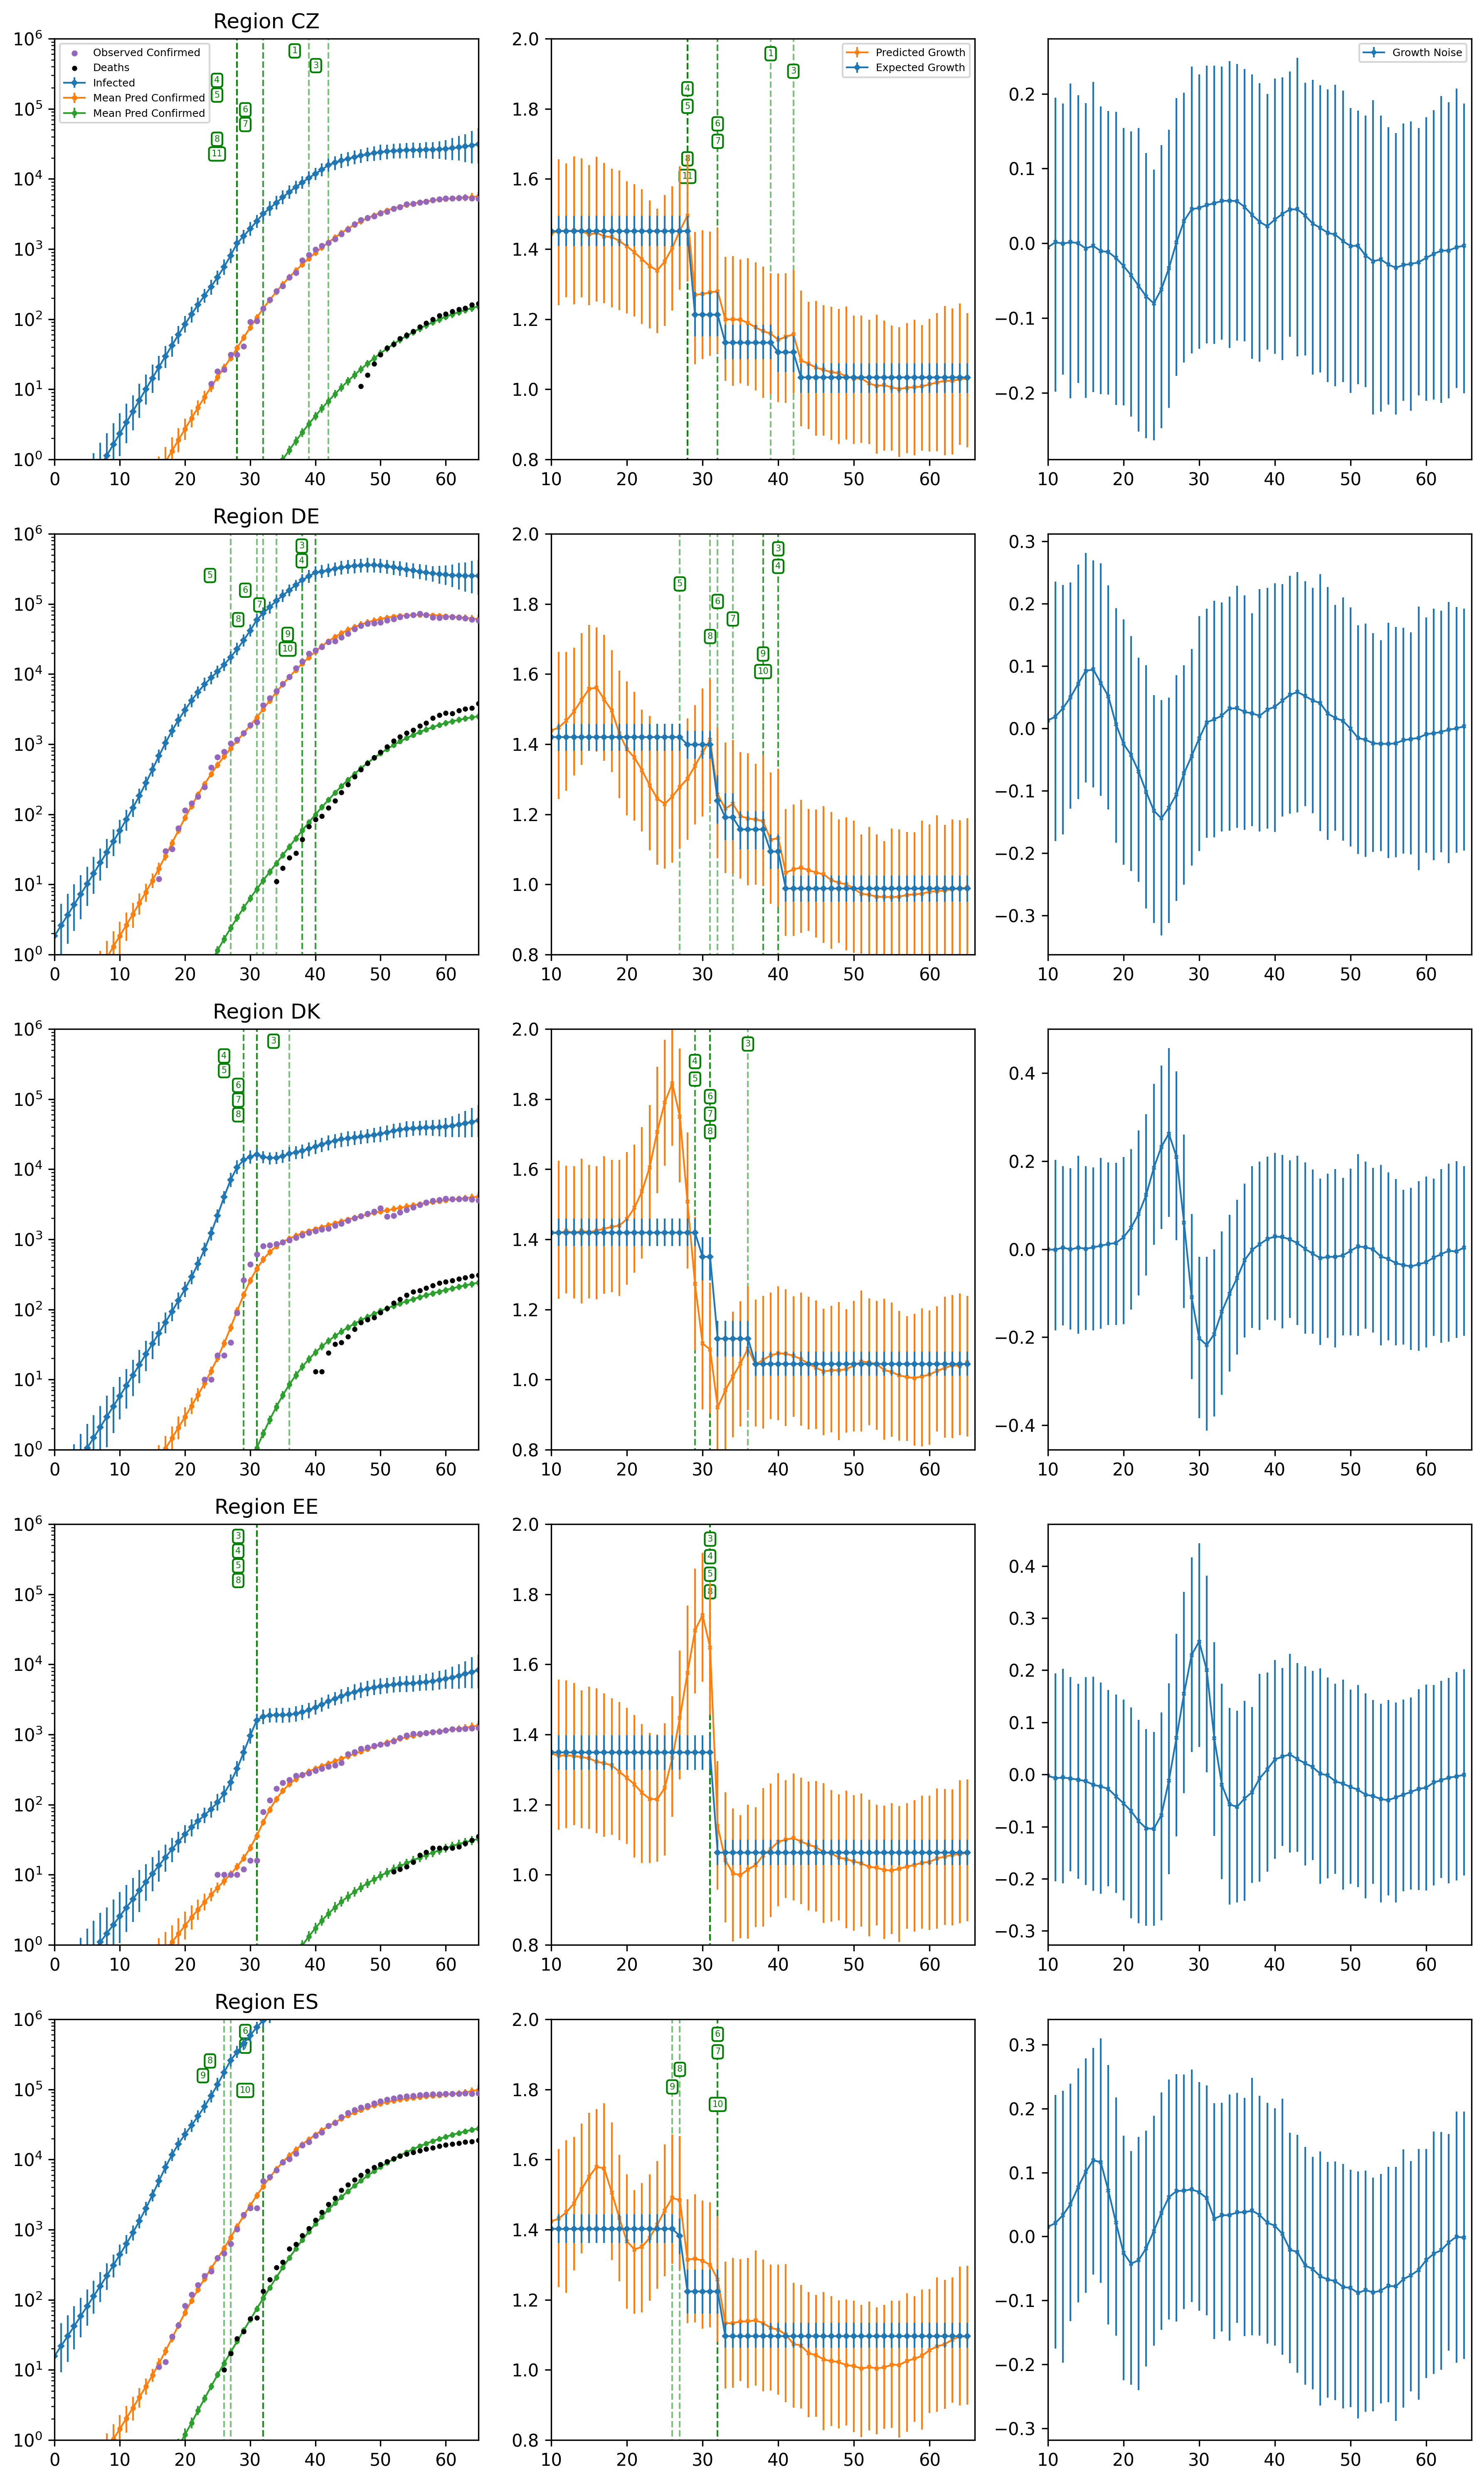

In [51]:
model2.OR_indxs = range(len(model.d.Rs))
model2.ORs = model.d.Rs
model2.plot_region_predictions()

In [32]:
model2.vars

[ConfirmationNoise_log__,
 DeathNoise_log__,
 HyperGrowthRateMean_log__,
 HyperGrowthRateVar_log__,
 RegionGrowthRate_log__,
 CM_Alpha_log__,
 DeathRate_logodds__,
 DelayCMean,
 DelayCAlpha,
 DelayDMean,
 DelayDAlpha,
 Growth,
 InitialSize,
 ObservedConfirmed_missing,
 ObservedDeaths_missing]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14e6efd60>,
      dtype=object)

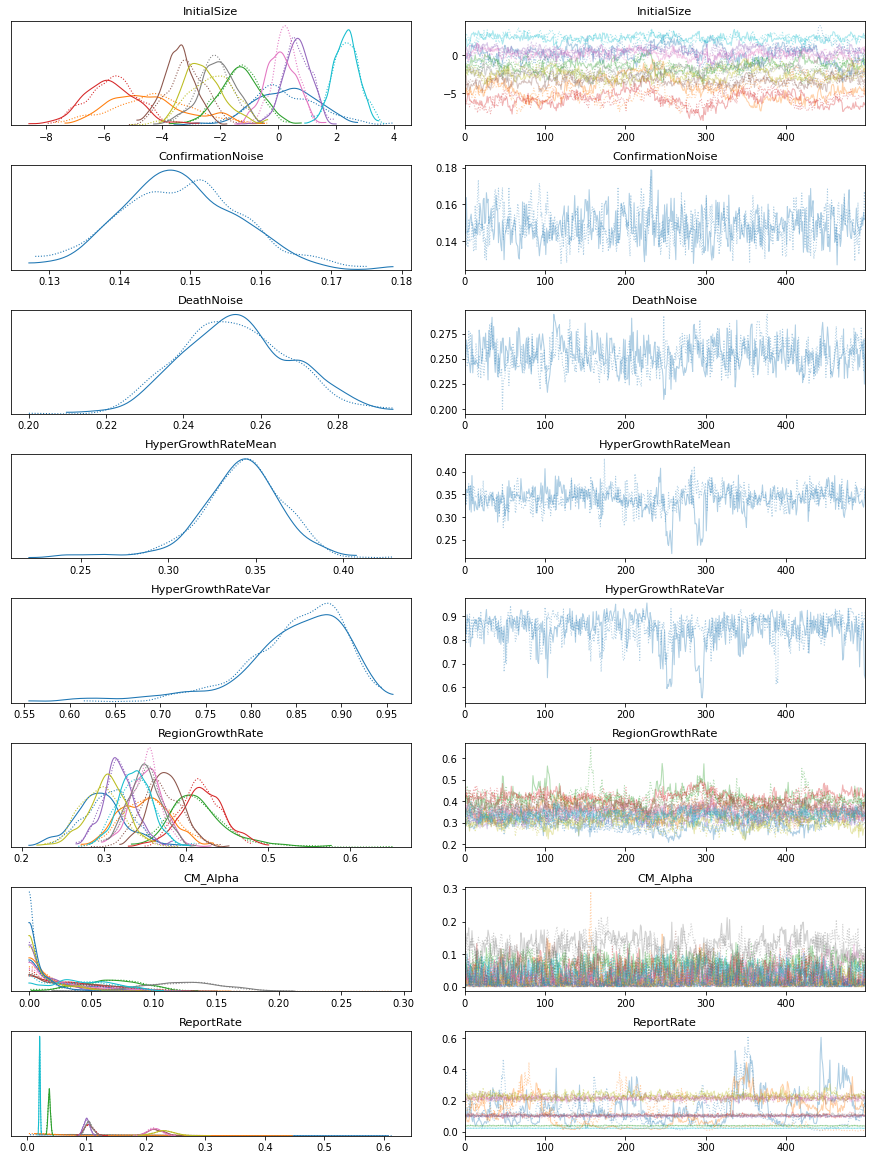

In [57]:
v =[
    'InitialSize',
    'ConfirmationNoise',
    'DeathNoise',
    'HyperGrowthRateMean',
    'HyperGrowthRateVar',
    'RegionGrowthRate',
    'CM_Alpha',
    'ReportRate',
    
]
pm.traceplot(model2.trace, v)

In [73]:
model2.trace['diverging'].nonzero()

(array([  75,  766,  767, 1036]),)

In [75]:
model2.trace.point(-1)

{'RegionGrowthRate_log__': array([-1.37413837, -1.15162077, -1.05259976, -0.94354963, -1.02776341,
        -1.33655549, -0.92285286, -1.20564241, -1.35012239, -1.38827474,
        -1.7437074 , -1.08776145, -1.15458227, -1.22542658, -1.32676596,
        -1.43395274, -1.26299759, -1.2456723 , -1.13422331, -1.35102629,
        -1.3954662 , -1.05045418, -2.48694756, -1.63320668, -1.32141612,
        -1.40567396, -1.2130382 , -1.13452808, -1.2962928 , -1.13398013,
        -1.29110436, -1.65469186, -1.13811605, -1.25989048, -1.16487432]),
 'CM_Alpha_log__': array([-4.63757103, -4.09437889, -2.73913455, -7.39837872, -6.53226223,
        -7.81603029, -3.06132441, -2.21633127, -5.30033178, -2.90648375,
        -2.41579899]),
 'DeathRate_logodds__': -3.8836854094479003,
 'Growth': array([[ 0.27774115,  0.42747419,  0.16110259, ...,  0.32000848,
          0.15995851,  0.0604663 ],
        [ 0.36731264,  0.30122407,  0.21024138, ...,  0.03756581,
          0.03005444,  0.15920557],
        [ 0.386

In [81]:
pm.traceplot(model2.trace, ['CM_Alpha_log__'])

KeyError: "['CM_Alpha_log__'] var names are not present in dataset"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b87e940>,
      dtype=object)

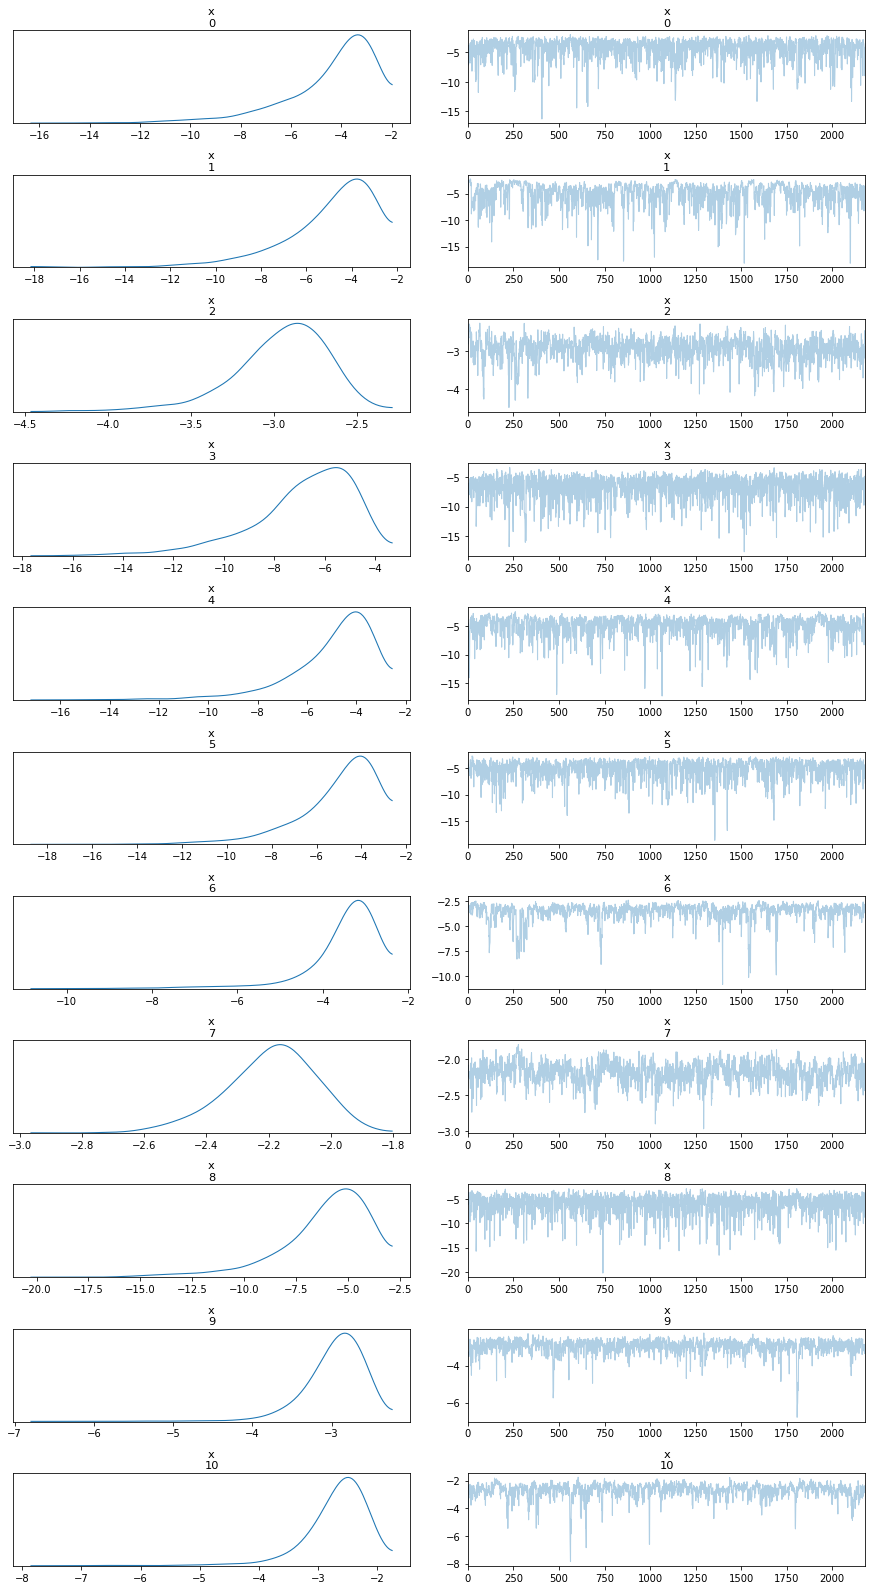

In [93]:
import arviz as az 
az.plot_trace(model2.trace['CM_Alpha_log__'][None, :,:])

In [91]:
model2.trace['CM_Alpha_log__'].shape

(2182, 11)

In [ ]:
data.